In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from datetime import datetime

In [2]:
# Load the data
df = pd.read_excel(r'C:\Users\FilePath\LRFMV_data.xlsx',sheet_name= 'walmart Retail Data')

In [3]:
df.head()

,City,Customer Age,Customer_ID,Customer Name,Customer Segment,Discount,Number of Records,Order Date,Order ID,Order Priority,...,Profit,Region,Row ID,Sales,Ship Date,Ship Mode,Shipping Cost,State,Unit Price,Zip Code
0,McKeesport,NaN,1,Jessica Myrick,Small Business,0.10,1,2012-01-01,28774,High,...,-111.80,East,4031,180.36,2012-01-02,Regular Air,4.69,Pennsylvania,5.98,15131
1,Bowie,NaN,2,Matt Collister,Home Office,0.08,1,2012-01-01,13729,Not Specified,...,-342.91,East,1914,872.48,2012-01-03,Express Air,35.00,Maryland,95.99,20715
2,Napa,NaN,3,Alan Schoenberger,Corporate,0.00,1,2012-01-02,37537,Low,...,-193.08,West,5272,1239.06,2012-01-02,Delivery Truck,48.80,California,291.73,94559
3,Montebello,NaN,4,Elizabeth Moffitt,Consumer,0.08,1,2012-01-02,44069,Critical,...,247.79,West,6225,614.80,2012-01-02,Regular Air,1.97,California,15.04,90640
4,Napa,NaN,3,Alan Schoenberger,Corporate,0.07,1,2012-01-02,37537,Low,...,-1049.85,West,5273,4083.19,2012-01-04,Delivery Truck,45.00,California,100.98,94559


In [4]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

In [5]:
# To analyze length and recency the end date is considered as the latest order_date
reference_date = df['Order Date'].max()

In [6]:
# Calculating LRFMV

In [9]:
# Calculating Length (Latency)
reference_date = df['Order Date'].max()
Length_df = df.groupby(["Customer_ID"])['Order Date'].min().apply(lambda date: (reference_date - date).days).reset_index()
Length_df.rename(columns={'Order Date': 'Length'}, inplace=True)

# Calculating RFM
agg_dict1 = {
    'Order ID': 'count',
    'Order Date': 'max',
    'Sales': 'sum'
}
df_rfm = df.groupby('Customer_ID').agg(agg_dict1).reset_index()
df_rfm.columns = ['Customer_ID', 'Frequency', 'max_date', 'Monetary']
df_rfm['Recency'] = (reference_date - df_rfm['max_date']).dt.days
df_rfm.drop(['max_date'], axis=1, inplace=True)

# Calculating Volume
df['MeanQuantityPerDay'] = df.groupby(['Customer_ID', 'Order Date'])['Order Quantity'].transform('mean')
Volume = df.groupby('Customer_ID')['MeanQuantityPerDay'].mean().reset_index()
Volume.rename(columns={'MeanQuantityPerDay': 'Volume'}, inplace=True)

# Combining all LRFMV metrics
lrfmv = Length_df.merge(df_rfm, on='Customer_ID', how='outer')
lrfmv = lrfmv.merge(Volume, on='Customer_ID', how='outer')

# Adding LRFMV metrics to the main dataframe
df = df.merge(lrfmv, on='Customer_ID', how='left')

# Clean up intermediate columns
df.drop(['MeanQuantityPerDay'], axis=1, inplace=True)
df

,City,Customer Age,Customer_ID,Customer Name,Customer Segment,Discount,Number of Records,Order Date,Order ID,Order Priority,...,Ship Mode,Shipping Cost,State,Unit Price,Zip Code,Length,Frequency,Monetary,Recency,Volume
0,McKeesport,NaN,1,Jessica Myrick,Small Business,0.10,1,2012-01-01,28774,High,...,Regular Air,4.69,Pennsylvania,5.98,15131,1459,10,10295.9200,246,25.800000
1,Bowie,NaN,2,Matt Collister,Home Office,0.08,1,2012-01-01,13729,Not Specified,...,Express Air,35.00,Maryland,95.99,20715,1459,17,23724.9280,291,30.588235
2,Napa,NaN,3,Alan Schoenberger,Corporate,0.00,1,2012-01-02,37537,Low,...,Delivery Truck,48.80,California,291.73,94559,1458,10,44571.9250,201,32.000000
3,Montebello,NaN,4,Elizabeth Moffitt,Consumer,0.08,1,2012-01-02,44069,Critical,...,Regular Air,1.97,California,15.04,90640,1458,7,6207.6450,611,20.857143
4,Napa,NaN,3,Alan Schoenberger,Corporate,0.07,1,2012-01-02,37537,Low,...,Delivery Truck,45.00,California,100.98,94559,1458,10,44571.9250,201,32.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8394,Fairfield,95.0,375,Tony Molinari,Corporate,0.10,1,2015-12-30,50950,Not Specified,...,Express Air,4.51,California,13.48,94533,1320,10,12002.0800,0,28.000000
8395,Harker Heights,95.0,770,Matt Hagelstein,Home Office,0.09,1,2015-12-30,25542,Low,...,Express Air,4.23,Texas,7.28,76543,672,3,683.9000,0,20.333333
8396,Riverview,95.0,202,Theresa Swint,Consumer,0.10,1,2015-12-30,45127,Medium,...,Regular Air,0.70,Florida,1.48,33569,1398,20,13119.3100,0,23.700000
8397,Nicholasville,95.0,692,Maribeth Yedwab,Home Office,0.09,1,2015-12-30,49344,Low,...,Regular Air,24.49,Kentucky,832.81,40356,982,10,10653.8195,0,24.100000


In [10]:
# Function to assign scores
def assign_score(x, bins):
    return pd.cut(x, bins=bins, labels=[1, 2, 3, 4, 5], include_lowest=True)

# Assign scores for each metric
lrfmv['L_Score'] = assign_score(lrfmv['Length'], bins=5)
lrfmv['R_Score'] = assign_score(lrfmv['Recency'], bins=5)
lrfmv['F_Score'] = assign_score(lrfmv['Frequency'], bins=5)
lrfmv['M_Score'] = assign_score(lrfmv['Monetary'], bins=5)
lrfmv['V_Score'] = assign_score(lrfmv['Volume'], bins=5)

# Converting categorical scores to numeric
score_columns = ['L_Score', 'R_Score', 'F_Score', 'M_Score', 'V_Score']
for col in score_columns:
    lrfmv[col] = lrfmv[col].cat.codes + 1  # Adding 1 because cat.codes are 0-indexed

# Calculating overall score
lrfmv['Overall_Score'] = lrfmv['L_Score'] + lrfmv['R_Score'] + lrfmv['F_Score'] + lrfmv['M_Score'] + lrfmv['V_Score']

In [11]:
# Segmneting the customers based on the scores
def segment_customers(row):
    score = row['Overall_Score']
    v_score = row['V_Score']
    r_score = row['R_Score']
    f_score = row['F_Score']
    
    if score >= 20:
        return 'Champions'
    elif score >= 18 and score < 20:
        return 'Loyal Customers'
    elif score >=16 and score < 18:
        return 'Potential Loyalists'
    elif r_score >= 4 and f_score >= 3:
        return 'Recent Customers'
    elif v_score >= 4:
        return 'High Volume Customers'
    elif score >= 14 and score < 16:
        return 'Promising Customers'
    elif score >=12 and score < 14:
        return 'About to Lose'
    elif score >=10 and score < 12:
        return 'At Risk'
    elif score >= 8 and score < 10:
        return 'Can Lose Them'
    else:
        return 'Dormant Customers'

# Apply the segmentation fnct
lrfmv['Segment'] = lrfmv.apply(segment_customers, axis=1)

In [12]:
lrfmv.groupby(['Segment','Overall_Score'])['Customer_ID'].count()

Segment                Overall_Score
About to Lose          12               149
                       13               105
At Risk                10               113
                       11               138
Can Lose Them          8                 20
                       9                 63
Dormant Customers      6                  3
                       7                 10
High Volume Customers  8                  1
                       9                  2
                       10                15
                       11                 7
                       12                20
                       13                21
                       14                15
                       15                 7
Loyal Customers        18                 3
Potential Loyalists    16                15
                       17                 5
Promising Customers    14                59
                       15                24
Name: Customer_ID, dtype: int64

In [13]:
lrfmv[(lrfmv['Segment']== 'Can Lose Them')]

,Customer_ID,Length,Frequency,Monetary,Recency,Volume,L_Score,R_Score,F_Score,M_Score,V_Score,Overall_Score,Segment
26,27,1454,6,6329.3885,189,13.000000,5,1,1,1,1,9,Can Lose Them
107,108,1435,4,4531.9120,263,10.250000,5,1,1,1,1,9,Can Lose Them
245,246,1382,4,1310.3850,119,13.500000,5,1,1,1,1,9,Can Lose Them
276,277,1373,7,4208.0480,249,10.857143,5,1,1,1,1,9,Can Lose Them
302,303,1363,4,555.8200,6,14.000000,5,1,1,1,1,9,Can Lose Them
...,...,...,...,...,...,...,...,...,...,...,...,...,...
779,780,589,8,7459.0475,118,24.000000,2,1,1,1,3,8,Can Lose Them
780,781,581,9,4605.2240,132,28.333333,2,1,1,1,3,8,Can Lose Them
782,783,558,6,18129.8615,97,25.500000,2,1,1,1,3,8,Can Lose Them
783,784,556,3,8396.5000,406,28.666667,2,2,1,1,3,9,Can Lose Them


## Analysis of LRFMV segments

C:\Users\Niveatha\AppData\Local\Temp\ipykernel_59588\1806929827.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


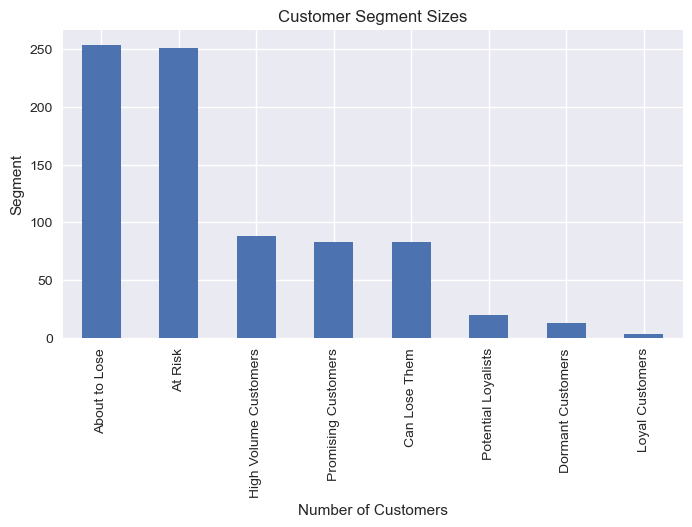

In [15]:
# Set the style for better-looking plots
plt.style.use('seaborn')

# 1. Bar plot of segment sizes
plt.figure(figsize=(8, 4))
segment_counts = lrfmv['Segment'].value_counts().sort_values(ascending=False)
segment_counts.plot(kind='bar')
plt.title('Customer Segment Sizes')
plt.xlabel('Number of Customers')
plt.ylabel('Segment')
plt.show()  


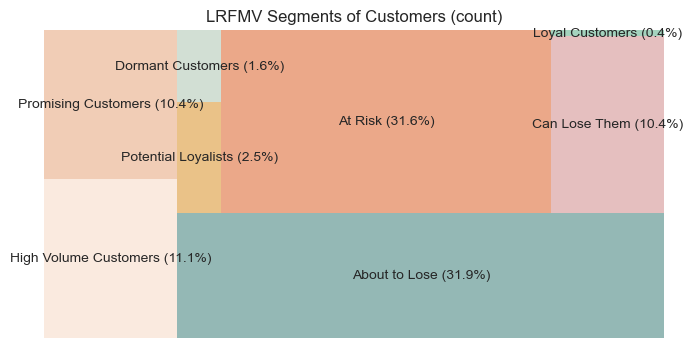

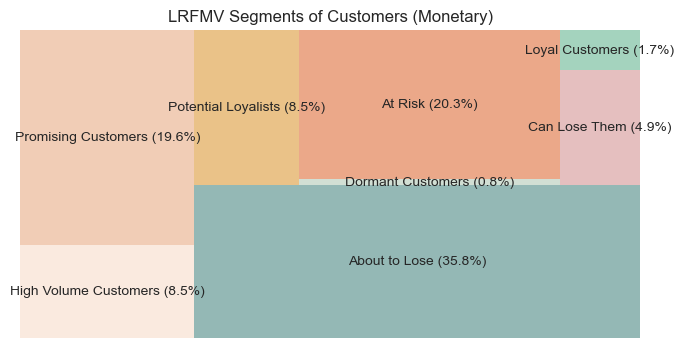

              Segment  count      Length    Recency  Frequency     Monetary    Volume  count_share  monetary_share  Total_Monetary
High Volume Customers     88 1152.261364 297.136364   7.022727 14349.777551 34.960230     0.110692        0.084662    1262780.4245
  Promising Customers     83 1373.867470 271.783133  18.301205 35207.575380 26.491365     0.104403        0.195918    2922228.7565
        About to Lose    254 1338.125984 260.826772  12.027559 20999.051969 25.724219     0.319497        0.357596    5333759.2000
  Potential Loyalists     20 1381.450000 231.800000  21.300000 63503.892050 29.930732     0.025157        0.085151    1270077.8410
    Dormant Customers     13  478.461538 211.923077   3.923077  9076.123769 19.681319     0.016352        0.007910     117989.6090
              At Risk    251 1228.326693 195.187251   8.322709 12072.628052 23.020449     0.315723        0.203158    3030229.6410
        Can Lose Them     83  974.987952 158.554217   6.530120  8719.543530 21.2772

In [24]:
# Defining the aggregation dictionary
agg_dict = {
    'Customer_ID': 'count',
    'Length': 'mean',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'sum',
    'Volume': 'mean'
}

# Grouping the Segment and aggregate
df_analysis = lrfmv.groupby('Segment').agg(agg_dict).reset_index()

# Renaming columns for clarity
df_analysis.rename({'Customer_ID': 'count'}, axis=1, inplace=True)

# Calculating the shares
df_analysis['count_share'] = df_analysis['count'] / df_analysis['count'].sum()
df_analysis['monetary_share'] = df_analysis['Monetary'] / df_analysis['Monetary'].sum()

# Storing the total Monetary value before calculating average
df_analysis['Total_Monetary'] = df_analysis['Monetary']

# Calculating the average monetary value per customer in each segment
df_analysis['Monetary'] = df_analysis['Monetary'] / df_analysis['count']

# Sorting by Recency
df_analysis = df_analysis.sort_values(by='Recency', ascending=False)

# Defining the color palette
colors = ['#F9E5D7', '#EEC1A4', '#79A6A3', '#E5B36A', '#C7D7CA', '#E7926C', '#dfb0b0', '#8EC9AE', '#F5D4C3', '#E09789']

# Treemaps for count and monetary value
for col, value_col in [('count', 'count'), ('Monetary', 'Total_Monetary')]:
    labels = df_analysis['Segment'] + df_analysis[col.lower() + '_share'].apply(lambda x: ' ({0:.1f}%)'.format(x*100))

    fig, ax = plt.subplots(figsize=(8,4))
    squarify.plot(sizes=df_analysis[value_col], label=labels, alpha=.8, color=colors[:len(df_analysis)])
    ax.set_title(f'LRFMV Segments of Customers ({col})')
    plt.axis('off')
    plt.show()

print(df_analysis.to_string(index=False))

C:\Users\Niveatha\AppData\Local\Temp\ipykernel_44748\31215847.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
C:\Users\Niveatha\AppData\Local\Temp\ipykernel_44748\31215847.py:26: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  scatter = sns.scatterplot(x=x_metric, y=y_metric, data=segment_means, hue='Segment',
C:\Users\Niveatha\AppData\Local\Temp\ipykernel_44748\31215847.py:26: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  scatter = sns.scatterplot(x=x_metric, y=y_metric, data=segment_means, hue='Segment',
C:\Users\Niveatha\AppData\Local\Temp\ipykernel_44748\31215847.py:26: UserWarning: The palette list has more values (10) than n

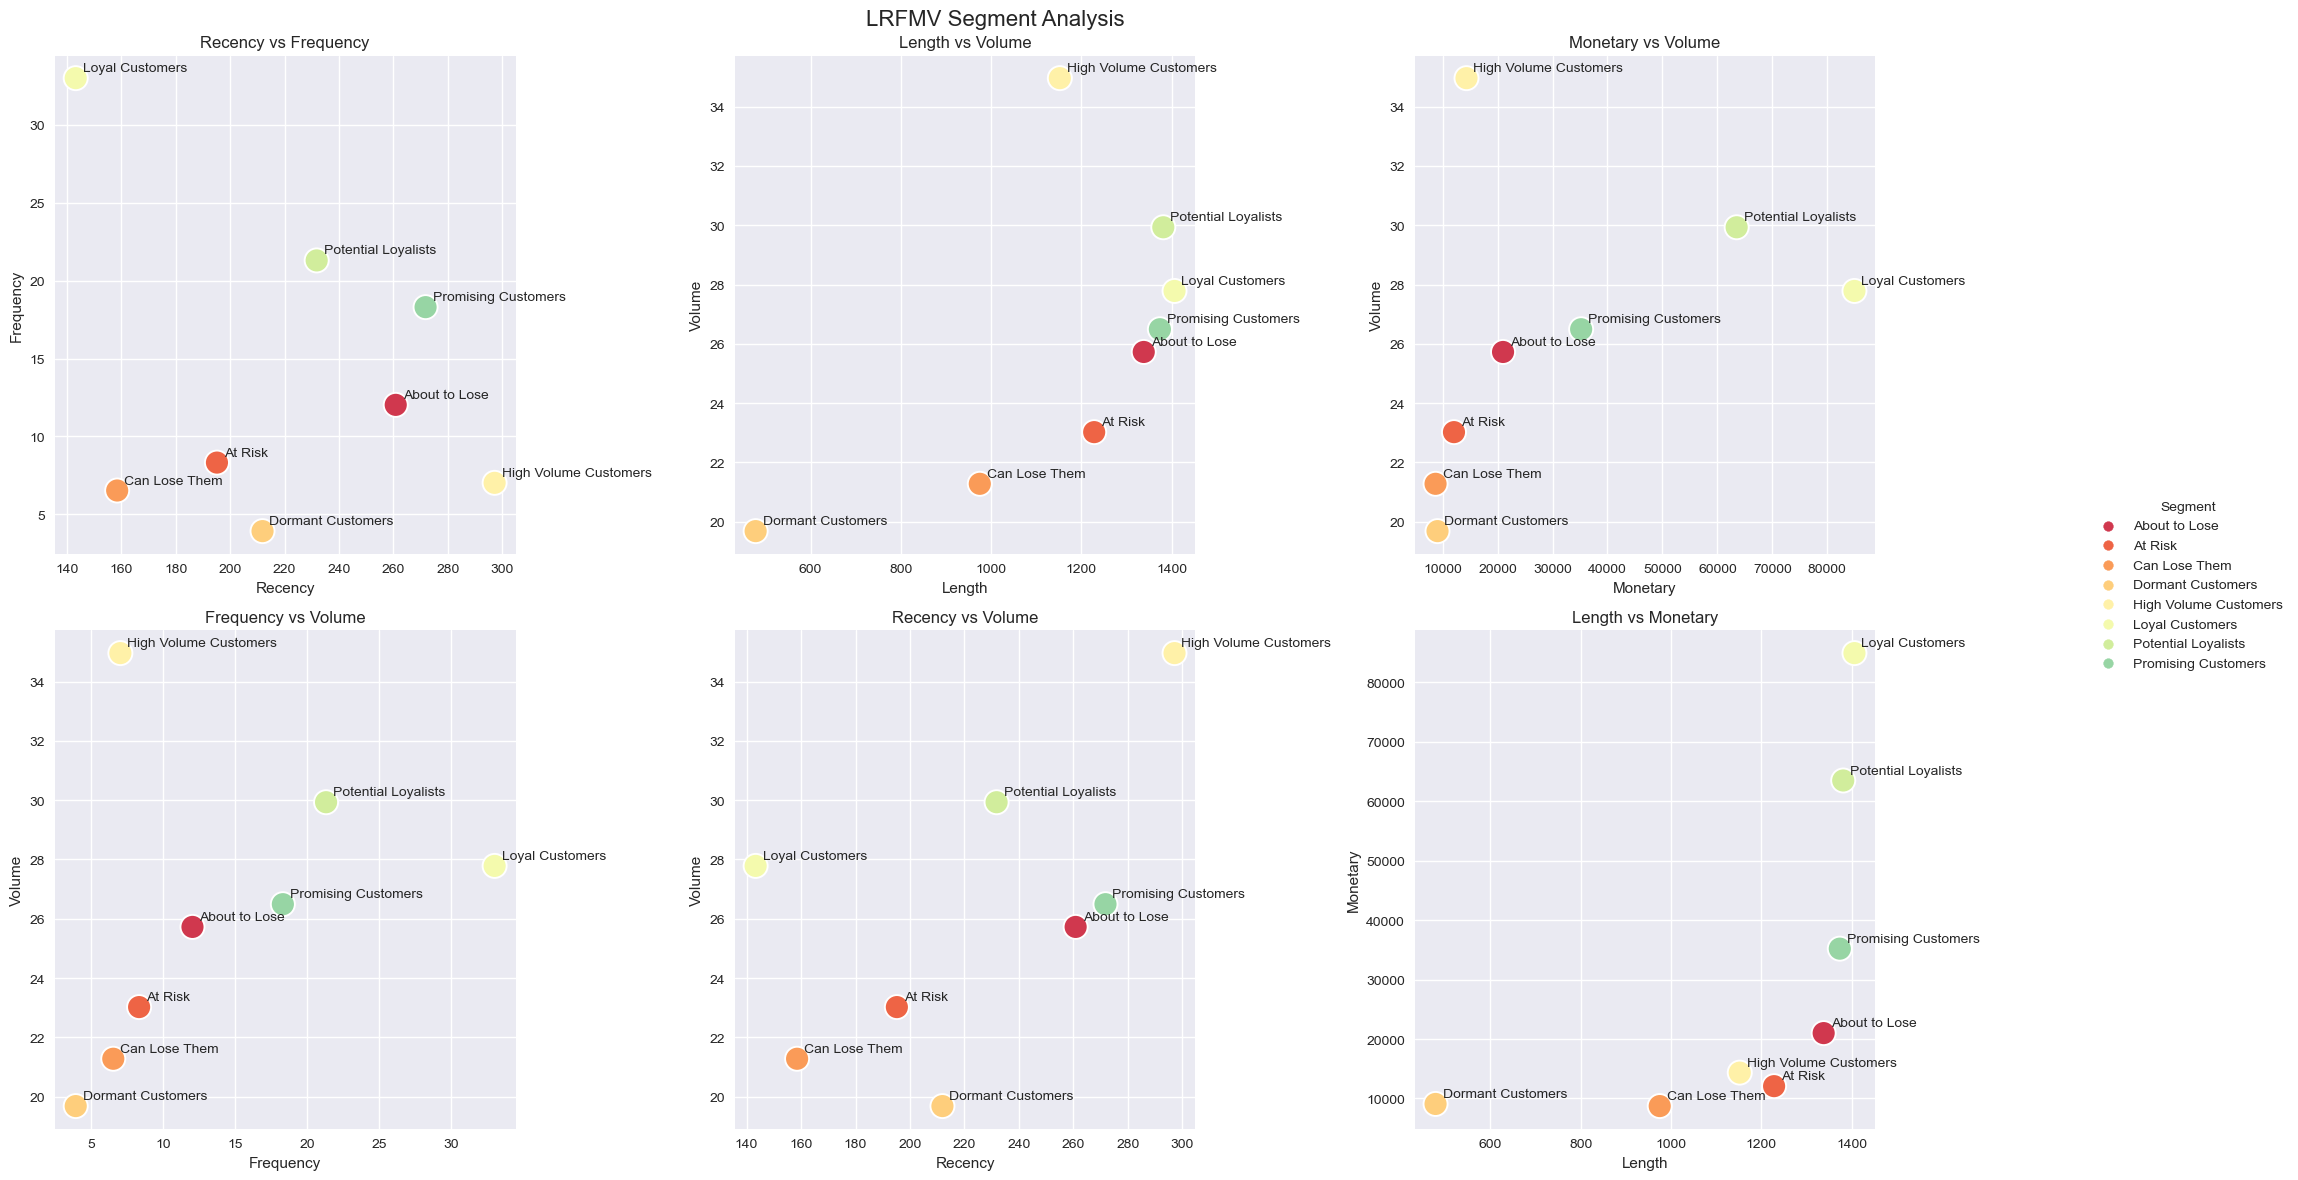

                      Length                                            \
                       count         mean         std     min      25%   
Segment                                                                  
About to Lose          254.0  1338.125984  102.521568   984.0  1276.25   
At Risk                251.0  1228.326693  170.147127   734.0  1114.50   
Can Lose Them           83.0   974.987952  219.851807   510.0   846.50   
Dormant Customers       13.0   478.461538  196.651814   223.0   322.00   
High Volume Customers   88.0  1152.261364  263.624275   314.0   966.00   
Loyal Customers          3.0  1406.333333   58.106225  1342.0  1382.00   
Potential Loyalists     20.0  1381.450000   68.568425  1200.0  1356.25   
Promising Customers     83.0  1373.867470   78.221039  1113.0  1337.50   

                                               Recency              ...  \
                          50%      75%     max   count        mean  ...   
Segment                            

In [504]:
# Calculate the mean values for each segment
segment_means = lrfmv.groupby('Segment')[['Length', 'Recency', 'Frequency', 'Monetary', 'Volume']].mean().reset_index()

# Creating a list of all possible combinations of LRFMV metrics
metric_combinations = [
    ('Recency', 'Frequency'),
    ('Length', 'Volume'),
    ('Monetary', 'Volume'),
    ('Frequency', 'Volume'),
    ('Recency', 'Volume'),
    ('Length', 'Monetary')
]

# Set up the plot style
plt.style.use('seaborn')
palette = sns.color_palette("Spectral", 10)

# Create subplots for each combination
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('LRFMV Segment Analysis', fontsize=16)

for i, (x_metric, y_metric) in enumerate(metric_combinations):
    ax = axes[i // 3, i % 3]
    
    # Use segment_means instead of lrfmv
    scatter = sns.scatterplot(x=x_metric, y=y_metric, data=segment_means, hue='Segment', 
                              s=300, palette=palette, ax=ax)
    
    # Add labels to each point
    for j, row in segment_means.iterrows():
        ax.annotate(row['Segment'], (row[x_metric], row[y_metric]), 
                    xytext=(5, 5), textcoords='offset points')
    
    ax.set_title(f'{x_metric} vs {y_metric}')
    ax.set_xlabel(x_metric)
    ax.set_ylabel(y_metric)
    
    # Remove the legend for each subplot
    ax.get_legend().remove()

# Add a single legend for the entire figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='Segment', loc='center right', bbox_to_anchor=(1.15, 0.5))

plt.tight_layout()
plt.show()

# Create a correlation heatmap
#plt.figure(figsize=(10, 8))
#correlation_matrix = lrfmv[['Length', 'Recency', 'Frequency', 'Monetary', 'Volume']].corr()
#sns.heatmap(correlation_matrix, annot=True, cmap='BuGn', vmin=-1, vmax=1, center=0)
#plt.title('Correlation Heatmap of LRFMV Metrics')
#plt.show()

# Print summary statistics for each segment
print(lrfmv.groupby('Segment')[['Length', 'Recency', 'Frequency', 'Monetary', 'Volume']].describe())

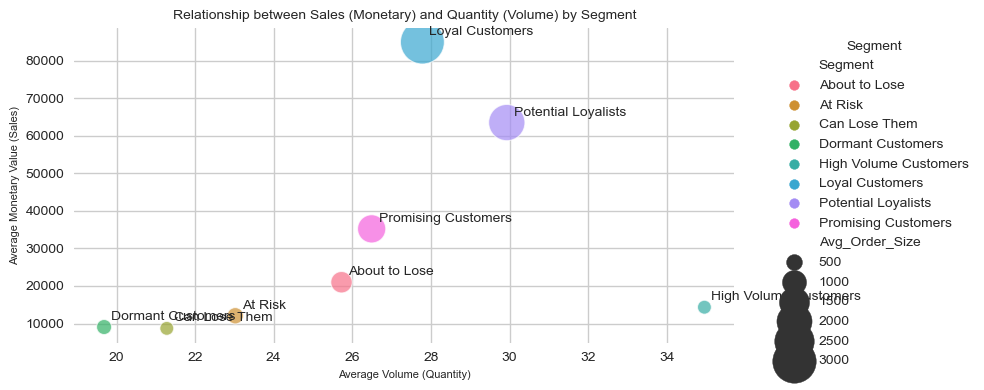

                 Segment      Monetary     Volume  Avg_Order_Size
0          About to Lose  20999.051969  25.724219      816.314477
1                At Risk  12072.628052  23.020449      524.430615
2          Can Lose Them   8719.543530  21.277233      409.806277
3      Dormant Customers   9076.123769  19.681319      461.154251
4  High Volume Customers  14349.777551  34.960230      410.460042
5        Loyal Customers  84937.746333  27.782328     3057.258090
6    Potential Loyalists  63503.892050  29.930732     2121.695259
7    Promising Customers  35207.575380  26.491365     1329.020803


In [27]:
# Calculate the mean values for each segment
segment_means = lrfmv.groupby('Segment')[['Monetary', 'Volume']].mean().reset_index()

# Calculate average order size (Monetary / Volume)
segment_means['Avg_Order_Size'] = segment_means['Monetary'] / segment_means['Volume']

# Set up the plot style
plt.figure(figsize=(10, 4))
sns.set_style("whitegrid")

# Create the scatter plot
scatter = sns.scatterplot(x='Volume', y='Monetary', data=segment_means, 
                          hue='Segment', size='Avg_Order_Size', 
                          sizes=(100, 1000), alpha=0.7)

# Add labels to each point
for i, row in segment_means.iterrows():
    plt.annotate(row['Segment'], (row['Volume'], row['Monetary']), 
                 xytext=(5, 5), textcoords='offset points')

# Customize the plot
plt.title('Relationship between Sales (Monetary) and Quantity (Volume) by Segment', fontsize=10)
plt.xlabel('Average Volume (Quantity)', fontsize=8)
plt.ylabel('Average Monetary Value (Sales)', fontsize=8)

# Add a legend
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

# Print the segment means for reference
print(segment_means)

In [477]:
df_agg = df.groupby('Customer_ID')['Profit'].sum().reset_index()

In [478]:
merged_df = lrfmv.merge(df_agg, on='Customer_ID', how='left')

In [479]:
lrfmv['Profit'] = merged_df['Profit']

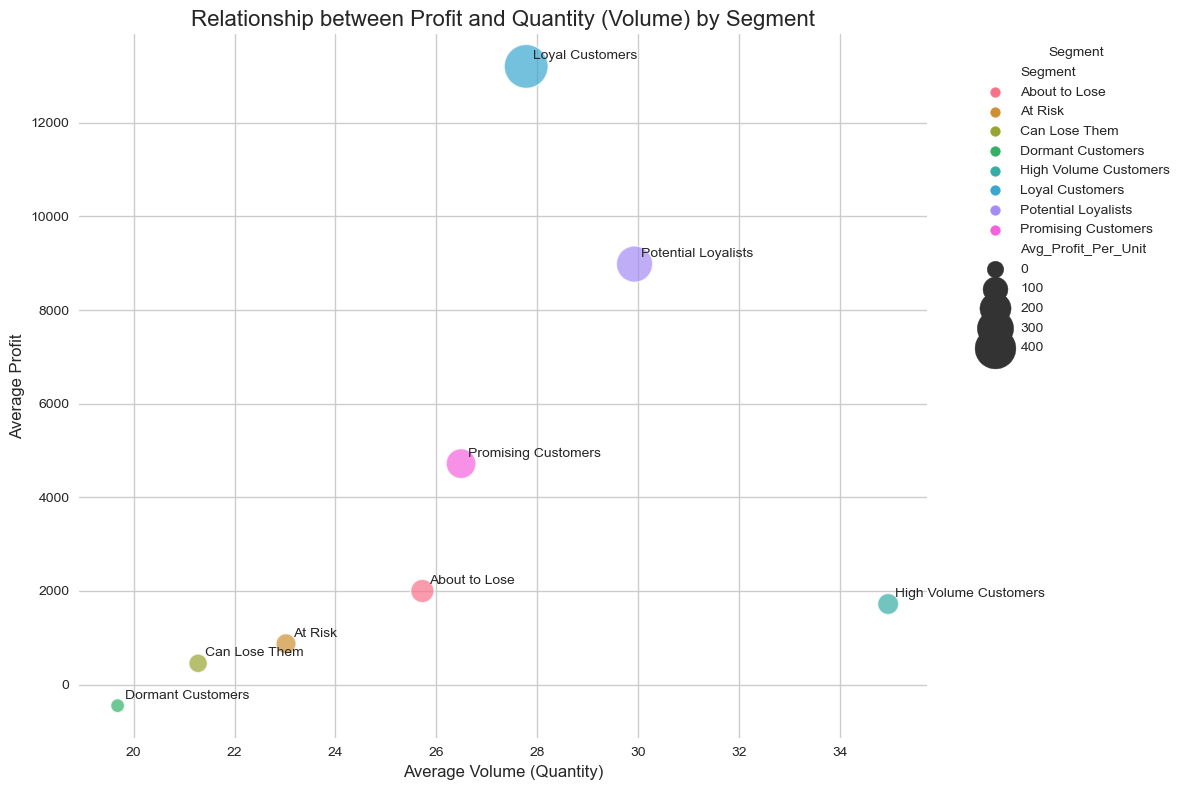

                 Segment        Profit     Volume  Avg_Profit_Per_Unit
0          About to Lose   2000.481233  25.724219            77.766453
1                At Risk    873.261546  23.020449            37.934167
2          Can Lose Them    455.220739  21.277233            21.394734
3      Dormant Customers   -449.295542  19.681319           -22.828528
4  High Volume Customers   1722.025157  34.960230            49.256688
5        Loyal Customers  13203.352433  27.782328           475.242843
6    Potential Loyalists   8981.098076  29.930732           300.062761
7    Promising Customers   4719.811645  26.491365           178.164153


In [480]:
# Calculate the mean values for each segment
segment_means = lrfmv.groupby('Segment')[['Profit', 'Volume']].mean().reset_index()

# Calculate average profit per unit
segment_means['Avg_Profit_Per_Unit'] = segment_means['Profit'] / segment_means['Volume']

# Set up the plot style
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Create the scatter plot
scatter = sns.scatterplot(x='Volume', y='Profit', data=segment_means, 
                          hue='Segment', size='Avg_Profit_Per_Unit', 
                          sizes=(100, 1000), alpha=0.7)

# Add labels to each point
for i, row in segment_means.iterrows():
    plt.annotate(row['Segment'], (row['Volume'], row['Profit']), 
                 xytext=(5, 5), textcoords='offset points')

# Customize the plot
plt.title('Relationship between Profit and Quantity (Volume) by Segment', fontsize=16)
plt.xlabel('Average Volume (Quantity)', fontsize=12)
plt.ylabel('Average Profit', fontsize=12)

# Add a legend
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

# Print the segment means for reference
print(segment_means)

In [481]:
df = df.merge(lrfmv, on='Customer_ID', how='left')

In [482]:
df.to_csv('lrfmv_output.csv')